In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Introduction

This notebook implements Logistic Regression for the two-class problem.

The steps are:
- Generate a synthetic dataset, pre-split into train/val/test sets.
- Create a LogisticRegression class to implement Logistic Regression.
- Train the classifier
- Evaluate its performance.

## Generating a synthetic dataset

In [2]:
def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

def synthetic_dataset(n_features, n_train, n_val, n_test):
    '''
    INPUTS
    
        n_features : number of input features
        n_train, n_val, n_test : number of train, validation and test examples.

    OUTPUTS
        
        X_train : The input data for training. Shape : (n_features, n_train).
        y_train : The labels for the training data. Shape : (1, n_train)
        X_val : The validation data. Shape : (n_features, n_val)
        y_val : The labels for the validation data. Shape : (1, n_val)
        X_test : The test data. Shape : (n_features, n_test)
        y_test : The labels for the test data. Shape : (1, n_test)
        
        Note that these shapes are same as the usual choice for neural networks, since logistic regression is being
        interpreted as a neural network with one layer and one unit in that layer.
    
    The function generates binary (0/1) labels for each input with n_features features.
    
    '''
    if (n_features == 2):
        X, y = make_classification(n_samples=n_train+n_val+n_test,
                                   n_features=n_features,     
                                   n_informative=2,  
                                   n_redundant=0,
                                   n_classes=2,
                                   n_clusters_per_class=1,
                                   random_state=42)   
    else:
        X, y = make_classification(n_samples=n_train+n_val+n_test,
                                   n_features=n_features,     
                                   n_informative=int(0.7*n_features),  
                                   n_redundant=int(0.3*n_features),
                                   n_classes=2,
                                   n_clusters_per_class=1,
                                   random_state=42)   
    
    #Split the data into training, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=n_test+n_val, random_state=42) 
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=n_test, random_state=42)

    # rescale each feature independently.
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    return X_train.T, y_train.reshape(1, -1), X_val.T, y_val.reshape(1, -1), X_test.T, y_test.reshape(1,-1)

In [3]:
X_train, y_train, X_val, y_val, X_test, y_test = synthetic_dataset(2,2000,1000,1000)

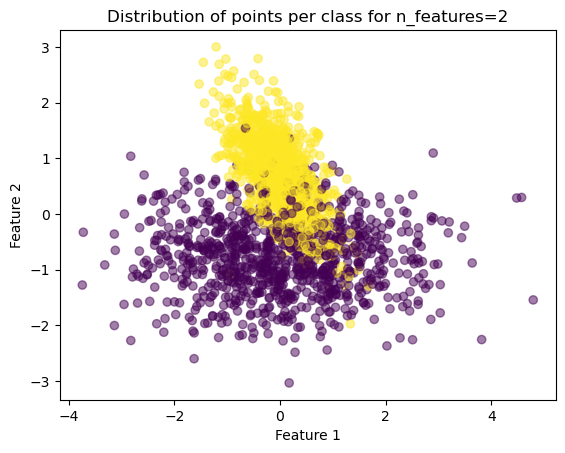

In [4]:
if (X_train.shape[0] == 2):
    plt.scatter(X_train[0, :], X_train[1, :], c=y_train, alpha=0.5)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Distribution of points per class for n_features=2")
    plt.show()

We see that the dataset is **not** linearly separable.

## Creating the Logistic Regression Classifier

note: we use the terms 'loss' and 'cost' interchangibly to mean 'cost', the average loss over the training set.

In [5]:
class LogisticRegression():

    def __init__(self, GD_num_iter, learning_rate, prettify):
        '''
        GD_num_iter : integer, number of iterations of Gradient Descent (GD) to be done.
        learning_rate : learning rate of GD.
        prettify: Add some additional print statements to indicate progress (bool, True or False).
        '''
        
        self.GD_num_iter = GD_num_iter
        self.learning_rate = learning_rate
        self.loss_history = []
        self._prettify = prettify 
        return

    def train(self, X, y):
        '''
        X : num_features by num_examples array.
        y : 1 by num_examples array.

        Return `parameters`, a dictionary containing the trained values of w, b, and the loss history.
        '''
        
        self._num_features, self._num_examples = X.shape
        assert (y.shape == (1, self._num_examples))
        self.w, self.b = self.__init_params()
        self.__GD(X, y)

        parameters = {"w" : self.w, "b" : self.b, "loss_history": self.loss_history}
        return parameters

    def __init_params(self):
        '''
        Initialize the parameters. 
        In this case, since we are performing logistic regression, the initial parameters are not important.
        This is because: 
            (1) The error surface is convex, so it is not important where we start, GD will eventually converge to the unique global minimum.
            (2) There is no symmetry breaking required for a single neuron in a single layer.
        '''
        w = np.zeros((self._num_features, 1))
        b = 0.0
        return w, b

    def __GD(self, X, y):
        '''
        Perform Gradient Descent. This function is meant to be called by train(), which is why it has a double underscore.
        It assumes that `self.w`, `self.b` are already initialized, and then performs `self.GD_num_iter` number of gradient descent steps.
        Progress can be monitored by setting `prettify=True` when initializing LogisticRegression instance.
        '''
        for i in range(self.GD_num_iter):
    
            # forward propagation
            yhat = sigmoid(np.dot(self.w.T, X)+self.b)
            self.J = self.__cost(yhat, y)
            self.loss_history.append(self.J)
            
            # backward propagation
            dJ_dw = np.dot(X, (yhat-y).T)/self._num_examples
            dJ_db = np.sum(yhat-y)/self._num_examples
            assert(dJ_dw.shape == self.w.shape)
            self.w = self.w - self.learning_rate*dJ_dw
            self.b = self.b - self.learning_rate*dJ_db

            # prettify
            if (self._prettify):
                print(f"Completed iteration {i+1}/{self.GD_num_iter}")
                print(f"Current Loss: {self.J.round(3)}")
                print(f"Current Gradients: dJ_dw = {dJ_dw.round(3)}, dJ_db = {dJ_db.round(3)}")
                print("-------------------------------------------------------------------------")
                
        return None
        
    def __cost(self, yhat, y):
        '''
        Compute the binary crossentropy loss averaged over all training examples.
        '''
        assert (yhat.shape == y.shape)
        assert (y.shape == (1, self._num_examples))
        l = -np.sum(y*np.log(yhat) + (1-y)*np.log(1-yhat))/self._num_examples
        return l

    def predict(self, X):
        '''
        make predictions in terms of **probability of positive class**. Note that the decision to use a threshold has to be applied **manually** later on.
        '''
        yhat = sigmoid(np.dot(self.w.T, X)+self.b)
        return yhat    

    ## some helper functions.
    def compute_classification_metrics(self, y_pred, y_true):
        '''
        Compute the precision, recall, F1 score and accuracy. This is a helper function.

        y_pred : predictions, after thresholding, of the inputs.
        y_true : true labels of the inputs.
        
        '''
        assert (y_pred.shape == y_true.shape)
        accuracy = np.mean(y_pred == y_true)
        true_positives = np.sum((y_pred == 1) * (y_true == 1))
        false_positives = np.sum((y_pred == 1) * (y_true == 0))
        true_negatives = np.sum((y_pred == 0) * (y_true == 0))
        false_negatives = np.sum((y_pred == 0) * (y_true == 1))
    
        precision =  true_positives/(true_positives+false_positives)
        recall = true_positives/(true_positives+false_negatives)
        f1 = 2.0*(precision*recall)/(precision+recall)

        print(f"accuracy: {accuracy.round(3)}")
        print(f"precision: {precision.round(3)}")
        print(f"recall: {recall.round(3)}")
        print(f"F1: {f1.round(3)}")
        
        return None


## Running the Classifier on the Synthetic Dataset

In [6]:
lr = LogisticRegression(GD_num_iter=10_000, learning_rate=0.006, prettify=False)

In [7]:
trained_params = lr.train(X_train, y_train)

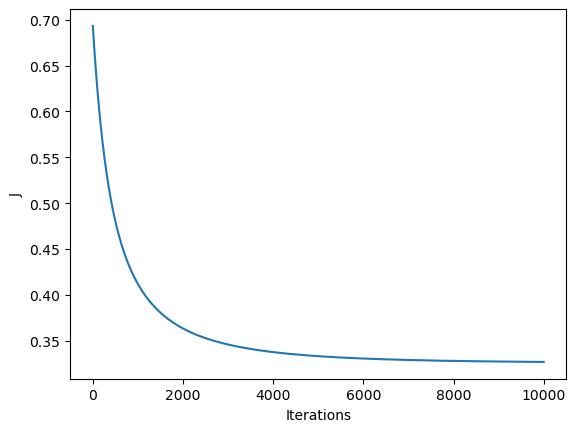

In [8]:
plt.plot(trained_params["loss_history"])
plt.xlabel("Iterations")
plt.ylabel("J")
plt.show()

We see that the cost function is monotonically decreasing, as expected.
We can predict the positive-class probabilities for the validation and test set now, as well as use a threshold of 0.5 to predict class labels and compute relevant metrics for classification performance.

In [9]:
y_train_proba = lr.predict(X_train)
y_val_proba = lr.predict(X_val)
y_test_proba = lr.predict(X_test)

In [10]:
y_train_pred = np.float64(y_train_proba >= 0.5)
y_val_pred = np.float64(y_val_proba >= 0.5)
y_test_pred = np.float64(y_test_proba >= 0.5)

In [11]:
print("Classification metrics for training set")
lr.compute_classification_metrics(y_train_pred, y_train)

Classification metrics for training set
accuracy: 0.861
precision: 0.861
recall: 0.866
F1: 0.864


In [12]:
print("Classification metrics for validation set")
lr.compute_classification_metrics(y_val_pred, y_val)

Classification metrics for validation set
accuracy: 0.858
precision: 0.839
recall: 0.861
F1: 0.85


In [13]:
print("Classification metrics for test set")
lr.compute_classification_metrics(y_test_pred, y_test)

Classification metrics for test set
accuracy: 0.87
precision: 0.89
recall: 0.852
F1: 0.871


We see that the scores for all the three are fairly similar. Thus, we are not overfitting to the training set.

### Comparing performance with sklearn's LogisticRegression class

In [14]:
from sklearn.linear_model import LogisticRegression as sk_LogisticRegression

In [15]:
sk_lr = sk_LogisticRegression(penalty=None, max_iter=5000, n_jobs=-1)

In [16]:
sk_lr.fit(X_train.T, y_train.reshape(-1))

LogisticRegression(max_iter=5000, n_jobs=-1, penalty=None)

In [17]:
from sklearn.metrics import precision_recall_fscore_support

In [18]:
y_train_pred_sk = sk_lr.predict(X_train.T)
prec_train_sk, rec_train_sk, f1_train_sk, _ = precision_recall_fscore_support(y_train.reshape(-1), y_train_pred_sk.reshape(-1), average='binary')
print("Precision on Training Set (sklearn model):",prec_train_sk.round(3))
print("Recall on Training Set (sklearn model):",rec_train_sk.round(3))
print("F1 score on Training set (sklearn model):", f1_train_sk.round(3))

Precision on Training Set (sklearn model): 0.861
Recall on Training Set (sklearn model): 0.866
F1 score on Training set (sklearn model): 0.864


In [19]:
y_val_pred_sk = sk_lr.predict(X_val.T)
prec_val_sk, rec_val_sk, f1_val_sk, _ = precision_recall_fscore_support(y_val.reshape(-1), y_val_pred_sk.reshape(-1), average='binary')
print("Precision on Validation Set (sklearn model):",prec_val_sk.round(3))
print("Recall on Validation Set (sklearn model):",rec_val_sk.round(3))
print("F1 score on Validation set (sklearn model):", f1_val_sk.round(3))

Precision on Validation Set (sklearn model): 0.839
Recall on Validation Set (sklearn model): 0.858
F1 score on Validation set (sklearn model): 0.848


In [20]:
y_test_pred_sk = sk_lr.predict(X_test.T)
prec_test_sk, rec_test_sk, f1_test_sk, _ = precision_recall_fscore_support(y_test.reshape(-1), y_test_pred_sk.reshape(-1), average='binary')
print("Precision on Test Set (sklearn model):",prec_test_sk.round(3))
print("Recall on Test Set (sklearn model):",rec_test_sk.round(3))
print("F1 score on Test set (sklearn model):", f1_test_sk.round(3))

Precision on Test Set (sklearn model): 0.89
Recall on Test Set (sklearn model): 0.852
F1 score on Test set (sklearn model): 0.871


The performance is quite similar. Thus, we can conclude that the `LogisticRegression` class is performing well.

### Visualizing the Decision Boundary

In [21]:
def plot_decision_boundary(X, y, f, resolution=0.01):
    # Set up color map for background
    colors = ('pink', 'lightblue')
    cmap = ListedColormap(colors)

    
    x_min, x_max = X.min() - 1, X.max() + 1
    y_min, y_max = X.min() - 1, X.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))
    Z = (f(np.c_[xx.ravel(), yy.ravel()].T)>=0.5).astype(np.float64) # impose a decision threshold, since f = lr.predict() returns probabilities.
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    
    # Set up color map for data points.
    colors = ('red', 'blue')
    cmap = ListedColormap(colors)
    # Plot the data 
    plt.scatter(X[0,:], X[1,:], c=y, alpha=0.1, cmap=cmap)

    plt.title("Decision Boundary")
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

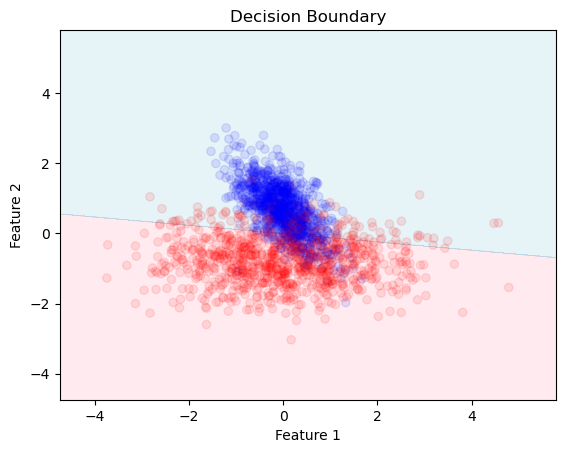

In [22]:
plot_decision_boundary(X_train, y_train, f=lr.predict)